# Simple Microscope Simulation - Spherical Inclusions

This notebook demonstrates simulating microscope imaging of a sample with multiple spherical inclusions using the `simple_microscope` function.

## Overview

We create a 2D sample with ~50 randomly placed spherical inclusions:
- Random positions across the field of view
- Random radii between 50-500 pixels (25-250 µm)
- Random refractive index contrast
- Projected to 2D transmission function for imaging

## Imports

In [1]:
import janssen as jns
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import cmocean.cm as cmo
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Circle

In [2]:
jns.__version__

'2025.10.4'

In [3]:
%load_ext autoreload
%autoreload 2

## Define Simulation Parameters

Same grid as USAF sample: 4096x4096 pixels at 0.5 µm pixel size.

In [ ]:
pixel_size = 0.5e-6  # 0.5 microns
num_pixels = 4096    # Same as USAF sample
wavelength = 633e-9  # 633 nm (HeNe laser)

# Sphere parameters
num_spheres = 100
min_radius_pixels = 50   # Minimum radius in pixels
max_radius_pixels = 500  # Maximum radius in pixels

# Refractive indices - almost transparent (small contrast, no absorption)
n_background = 1.0 + 0.0j  # Air/vacuum background

# Random seed for reproducibility
np.random.seed(42)

print(f"Pixel size: {pixel_size * 1e6:.1f} microns")
print(f"Grid size: {num_pixels} x {num_pixels} pixels")
print(f"Field of view: {pixel_size * num_pixels * 1e3:.2f} mm")
print(f"Wavelength: {wavelength * 1e9:.0f} nm")
print(f"Number of spheres: {num_spheres}")
print(f"Radius range: {min_radius_pixels}-{max_radius_pixels} pixels ({min_radius_pixels * pixel_size * 1e6:.0f}-{max_radius_pixels * pixel_size * 1e6:.0f} µm)")

## 1. Generate Random Sphere Parameters

Create random positions, radii, and refractive indices for all spheres.

In [ ]:
# Generate uniformly distributed sphere positions using grid + jitter
# Create a grid covering the full image (spheres can be cut off at edges)
grid_size = int(np.ceil(np.sqrt(num_spheres)))  # e.g., 8x8 grid for ~50 spheres

# No margin - spheres can extend to edges and be cut off
grid_spacing_y = num_pixels / grid_size
grid_spacing_x = num_pixels / grid_size

grid_y, grid_x = np.meshgrid(
    np.linspace(grid_spacing_y/2, num_pixels - grid_spacing_y/2, grid_size),
    np.linspace(grid_spacing_x/2, num_pixels - grid_spacing_x/2, grid_size)
)
grid_centers = np.stack([grid_y.ravel(), grid_x.ravel()], axis=1)

# Randomly select num_spheres positions from grid and add jitter
selected_indices = np.random.choice(len(grid_centers), num_spheres, replace=False)
sphere_centers = grid_centers[selected_indices]

# Add jitter (up to 25% of grid spacing for more uniform look)
jitter_amount = 0.25 * min(grid_spacing_y, grid_spacing_x)
sphere_centers_y = sphere_centers[:, 0] + np.random.uniform(-jitter_amount, jitter_amount, num_spheres)
sphere_centers_x = sphere_centers[:, 1] + np.random.uniform(-jitter_amount, jitter_amount, num_spheres)

# Radii: uniform distribution between min and max
sphere_radii_pixels = np.random.uniform(min_radius_pixels, max_radius_pixels, num_spheres)

# Refractive index - unique for each sphere, clustered values
# Bigger spheres are more transparent (smaller contrast), smaller spheres less transparent
# Normalize radius to [0, 1] range
radius_normalized = (sphere_radii_pixels - min_radius_pixels) / (max_radius_pixels - min_radius_pixels)

# Base refractive index with small random variation for each sphere
# Real part: smaller spheres have higher contrast (n ~ 1.008), bigger spheres lower (n ~ 1.003)
# Add small unique variation to each
base_n_real = 1.003 + 0.005 * (1 - radius_normalized)  # Inversely proportional to size
sphere_n_real = base_n_real + np.random.uniform(-0.0005, 0.0005, num_spheres)  # Small unique variation

# Imaginary part: smaller spheres have more absorption, bigger spheres less
# Smaller spheres: κ ~ 0.0003, bigger spheres: κ ~ 0.00005
base_n_imag = 0.00005 + 0.00025 * (1 - radius_normalized)  # Inversely proportional to size
sphere_n_imag = base_n_imag + np.random.uniform(-0.00002, 0.00002, num_spheres)  # Small unique variation
sphere_n_imag = np.maximum(sphere_n_imag, 0)  # Ensure non-negative

sphere_n = sphere_n_real + 1j * sphere_n_imag

print(f"Generated {num_spheres} spheres with uniform distribution")
print(f"Grid: {grid_size}x{grid_size} = {grid_size**2} positions, selected {num_spheres}")
print(f"Grid spacing: {grid_spacing_y:.0f} x {grid_spacing_x:.0f} pixels")
print(f"Center Y range: {sphere_centers_y.min():.0f} to {sphere_centers_y.max():.0f} pixels")
print(f"Center X range: {sphere_centers_x.min():.0f} to {sphere_centers_x.max():.0f} pixels")
print(f"Radius range: {sphere_radii_pixels.min():.0f} to {sphere_radii_pixels.max():.0f} pixels")
print(f"Refractive index (real) range: {sphere_n_real.min():.5f} to {sphere_n_real.max():.5f}")
print(f"Absorption (imag) range: {sphere_n_imag.min():.6f} to {sphere_n_imag.max():.6f}")
print(f"Contrast (n-1) range: {(sphere_n_real-1).min():.5f} to {(sphere_n_real-1).max():.5f}")

## 2. Create 2D Sample with Spherical Projections

For each sphere, we compute the 2D projection (optical path length through a sphere).
For a sphere of radius R centered at origin, the path length at position (x,y) is:
$L(x,y) = 2\sqrt{R^2 - x^2 - y^2}$ for $x^2 + y^2 < R^2$

In [6]:
# Create 2D sample with projected spheres using vmap
# Create coordinate grids
y_coords = jnp.arange(num_pixels)
x_coords = jnp.arange(num_pixels)
yy, xx = jnp.meshgrid(y_coords, x_coords, indexing='ij')

# Wave number
k = 2 * jnp.pi / wavelength

# Convert sphere parameters to JAX arrays
centers_y = jnp.array(sphere_centers_y)
centers_x = jnp.array(sphere_centers_x)
radii = jnp.array(sphere_radii_pixels)
n_spheres_arr = jnp.array(sphere_n)

def compute_sphere_transmission(cy, cx, radius, n_sphere):
    """Compute transmission contribution from a single sphere."""
    # Distance from sphere center (in pixels)
    dist_sq = (yy - cy)**2 + (xx - cx)**2
    
    # Path length through sphere (in meters)
    # L = 2 * sqrt(R^2 - r^2) for r < R, else 0
    path_length_pixels = 2 * jnp.sqrt(jnp.maximum(radius**2 - dist_sq, 0))
    path_length_meters = path_length_pixels * pixel_size
    
    # Phase and amplitude from this sphere
    delta_n = n_sphere - n_background
    sphere_transmission = jnp.exp(1j * k * delta_n * path_length_meters)
    
    return sphere_transmission

# vmap over all spheres and multiply contributions together
all_transmissions = jax.vmap(compute_sphere_transmission)(centers_y, centers_x, radii, n_spheres_arr)

# Product of all sphere transmissions (shape: num_pixels x num_pixels)
sample_transmission = jnp.prod(all_transmissions, axis=0)

print(f"Sample created using vmap!")
print(f"Amplitude range: {jnp.abs(sample_transmission).min():.4f} to {jnp.abs(sample_transmission).max():.4f}")
print(f"Phase range: {jnp.angle(sample_transmission).min():.4f} to {jnp.angle(sample_transmission).max():.4f} rad")

Sample created using vmap!
Amplitude range: 0.0071 to 1.0000
Phase range: -3.1416 to 3.1416 rad


In [7]:
# Create sample function
sphere_sample = jns.utils.make_sample_function(
    sample=sample_transmission,
    dx=pixel_size,
)

print(f"Sample shape: {sphere_sample.sample.shape}")
print(f"Sample dx: {sphere_sample.dx * 1e6:.2f} microns")

Sample shape: (4096, 4096)
Sample dx: 0.50 microns


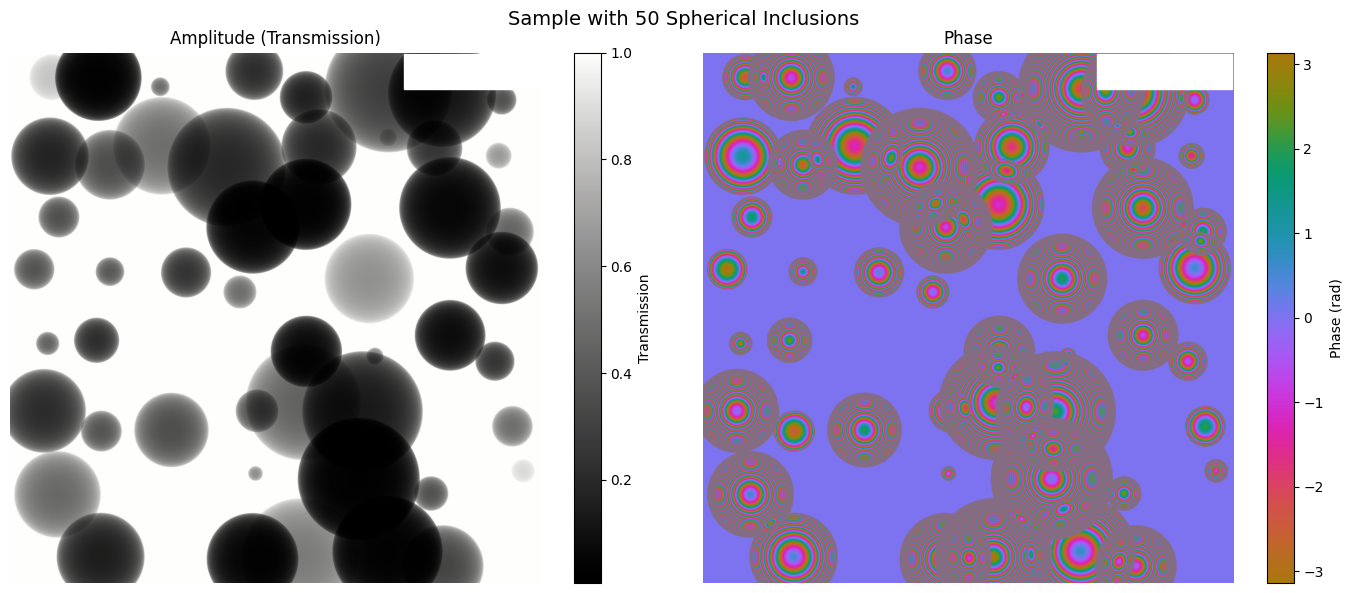

In [8]:
# Visualize the sample
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

amp = jnp.abs(sphere_sample.sample)
phase = jnp.angle(sphere_sample.sample)

# Amplitude
im0 = axes[0].imshow(amp, cmap=cmo.gray)
axes[0].set_title('Amplitude (Transmission)')
scalebar = ScaleBar(sphere_sample.dx, 'm', length_fraction=0.25, color='white')
axes[0].add_artist(scalebar)
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], label='Transmission')

# Phase
im1 = axes[1].imshow(phase, cmap=cmo.phase, vmin=-jnp.pi, vmax=jnp.pi)
axes[1].set_title('Phase')
scalebar = ScaleBar(sphere_sample.dx, 'm', length_fraction=0.25, color='white')
axes[1].add_artist(scalebar)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], label='Phase (rad)')

plt.suptitle(f'Sample with {num_spheres} Spherical Inclusions', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Create Illumination Wavefront

In [9]:
illumination_size = 256  # Same as USAF notebook

lightwave = jns.models.plane_wave(
    wavelength=wavelength,
    dx=pixel_size,
    grid_size=(illumination_size, illumination_size),
    amplitude=1.0,
)

print(f"Illumination field shape: {lightwave.field.shape}")
print(f"Illumination wavelength: {lightwave.wavelength * 1e9:.0f} nm")
print(f"Illumination dx: {lightwave.dx * 1e6:.2f} microns")
print(f"Illumination FOV: {illumination_size * pixel_size * 1e6:.0f} microns")

Illumination field shape: (256, 256)
Illumination wavelength: 633 nm
Illumination dx: 0.50 microns
Illumination FOV: 128 microns


## 4. Set Microscope Parameters

In [10]:
# Microscope parameters
zoom_factor = 10.0  # 10x magnification
aperture_diameter = 1e-3  # 1 mm aperture
travel_distance = 0.15  # 150 mm to camera
detector_pixel_size = jnp.array(16e-6)  # 16 micron camera pixels

print(f"Zoom factor: {zoom_factor}x")
print(f"Aperture diameter: {aperture_diameter * 1e3:.1f} mm")
print(f"Travel distance: {travel_distance * 1e3:.0f} mm")
print(f"Detector pixel size: {detector_pixel_size * 1e6:.1f} µm")

Zoom factor: 10.0x
Aperture diameter: 1.0 mm
Travel distance: 150 mm
Detector pixel size: 16.0 µm


## 5. Single Diffractogram Test

Test with a single position at the center of the sample.

In [11]:
# Cut sample at center
center_pixel = num_pixels // 2
half_size = illumination_size // 2
sample_cut = sphere_sample.sample[
    center_pixel - half_size : center_pixel + half_size,
    center_pixel - half_size : center_pixel + half_size
]

sample_region = jns.utils.make_sample_function(
    sample=sample_cut,
    dx=pixel_size,
)

# Generate single diffractogram
diffractogram = jns.scopes.simple_diffractogram(
    sample_cut=sample_region,
    lightwave=lightwave,
    zoom_factor=zoom_factor,
    aperture_diameter=aperture_diameter,
    travel_distance=travel_distance,
    camera_pixel_size=detector_pixel_size,
)

print(f"Diffractogram shape: {diffractogram.image.shape}")
print(f"Diffractogram dx: {diffractogram.dx * 1e6:.2f} µm")

Diffractogram shape: (256, 256)
Diffractogram dx: 16.00 µm


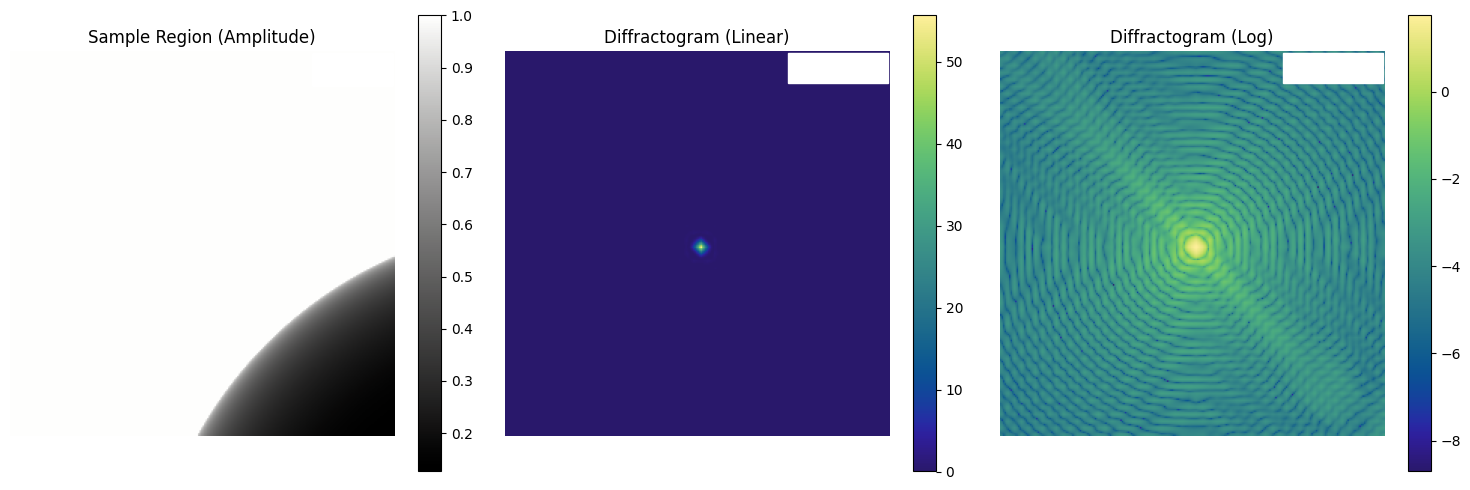

In [12]:
# Visualize single diffractogram
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sample region
im0 = axes[0].imshow(jnp.abs(sample_region.sample), cmap=cmo.gray)
axes[0].set_title('Sample Region (Amplitude)')
scalebar = ScaleBar(sample_region.dx, 'm', length_fraction=0.25, color='white')
axes[0].add_artist(scalebar)
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0])

# Diffractogram - linear scale
im1 = axes[1].imshow(diffractogram.image, cmap=cmo.haline)
axes[1].set_title('Diffractogram (Linear)')
scalebar = ScaleBar(diffractogram.dx, 'm', length_fraction=0.25, color='white')
axes[1].add_artist(scalebar)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1])

# Diffractogram - log scale
im2 = axes[2].imshow(jnp.log10(diffractogram.image + 1e-10), cmap=cmo.haline)
axes[2].set_title('Diffractogram (Log)')
scalebar = ScaleBar(diffractogram.dx, 'm', length_fraction=0.25, color='white')
axes[2].add_artist(scalebar)
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

## 6. Full Microscope Simulation - Scanning

Create scan positions and run the full microscope simulation.

In [13]:
# Create scan positions centered on a region with spheres
scan_step = 15e-6  # 15 micron step size (same as USAF)
scan_pixel = scan_step / sphere_sample.dx

# Center of the sample
scope_center = jnp.array([num_pixels // 2, num_pixels // 2])  # (x, y) in pixels

num_scan_x = 20
num_scan_y = 20

xx, yy = jnp.meshgrid(
    jnp.arange(num_scan_x) * scan_pixel - (num_scan_x - 1) * scan_pixel / 2,
    jnp.arange(num_scan_y) * scan_pixel - (num_scan_y - 1) * scan_pixel / 2
)
x_positions = xx + scope_center[0]
y_positions = yy + scope_center[1]
positions = jnp.stack([x_positions.ravel(), y_positions.ravel()], axis=1)

print(f"Scan step: {scan_step * 1e6:.0f} µm ({scan_pixel:.1f} pixels)")
print(f"Number of scan positions: {len(positions)}")
print(f"Scan grid: {num_scan_x} x {num_scan_y}")
print(f"Total scan area: {(num_scan_x-1) * scan_step * 1e6:.0f} x {(num_scan_y-1) * scan_step * 1e6:.0f} µm")

Scan step: 15 µm (30.0 pixels)
Number of scan positions: 400
Scan grid: 20 x 20
Total scan area: 285 x 285 µm


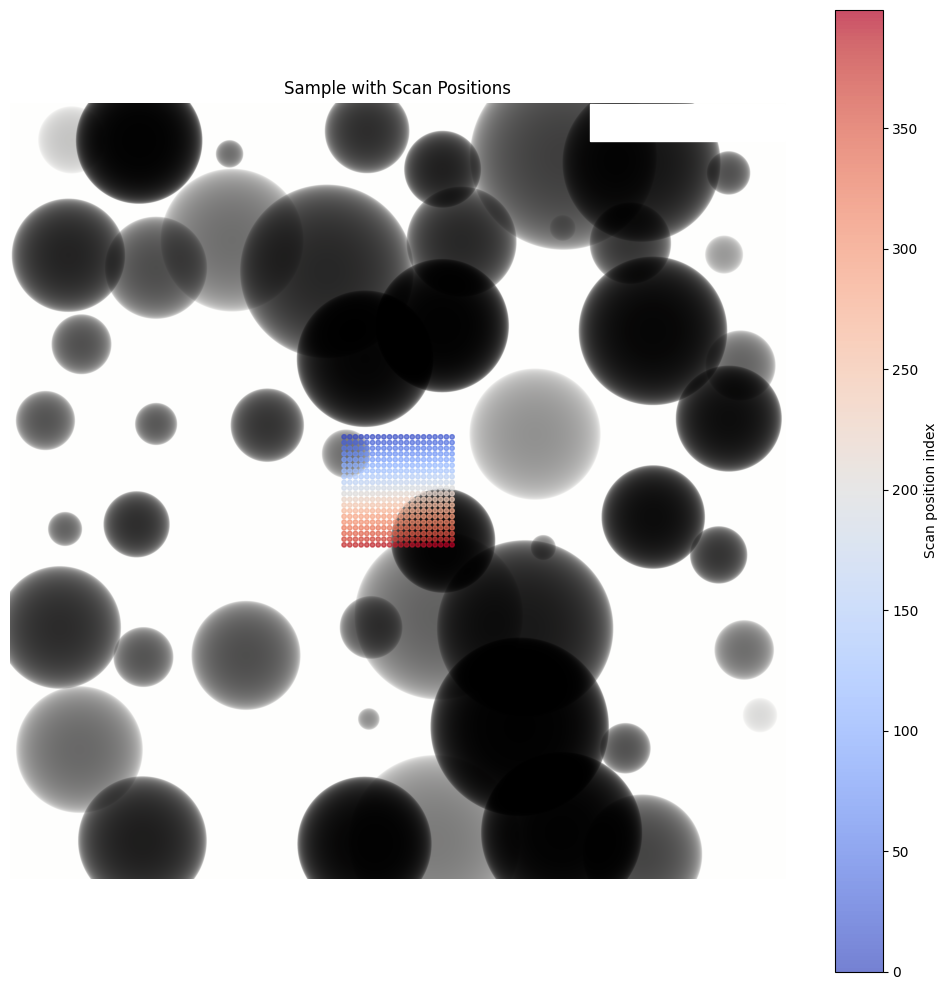

In [14]:
# Visualize scan positions on sample
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

im = ax.imshow(jnp.abs(sphere_sample.sample), cmap=cmo.gray)
ax.set_title('Sample with Scan Positions')
scalebar = ScaleBar(sphere_sample.dx, 'm', length_fraction=0.25, color='white')
ax.add_artist(scalebar)

# Add scan positions as colored dots
scatter = ax.scatter(positions[:, 0], positions[:, 1], 
                     c=jnp.arange(len(positions)), cmap='coolwarm', 
                     s=10, alpha=0.7, marker='o')
plt.colorbar(scatter, ax=ax, label='Scan position index')
ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Run simple_microscope with all scan positions
positions_meters = positions * sphere_sample.dx

microscope_data = jns.scopes.simple_microscope(
    sample=sphere_sample,
    positions=positions_meters,
    lightwave=lightwave,
    zoom_factor=zoom_factor,
    aperture_diameter=aperture_diameter,
    travel_distance=travel_distance,
    camera_pixel_size=detector_pixel_size,
)

print(f"Microscope data shape: {microscope_data.image_data.shape}")
print(f"Number of diffractograms: {microscope_data.image_data.shape[0]}")
print(f"Diffractogram size: {microscope_data.image_data.shape[1:]}")
print(f"Camera pixel size: {microscope_data.dx * 1e6:.2f} µm")

Microscope data shape: (400, 256, 256)
Number of diffractograms: 400
Diffractogram size: (256, 256)
Camera pixel size: 16.00 µm


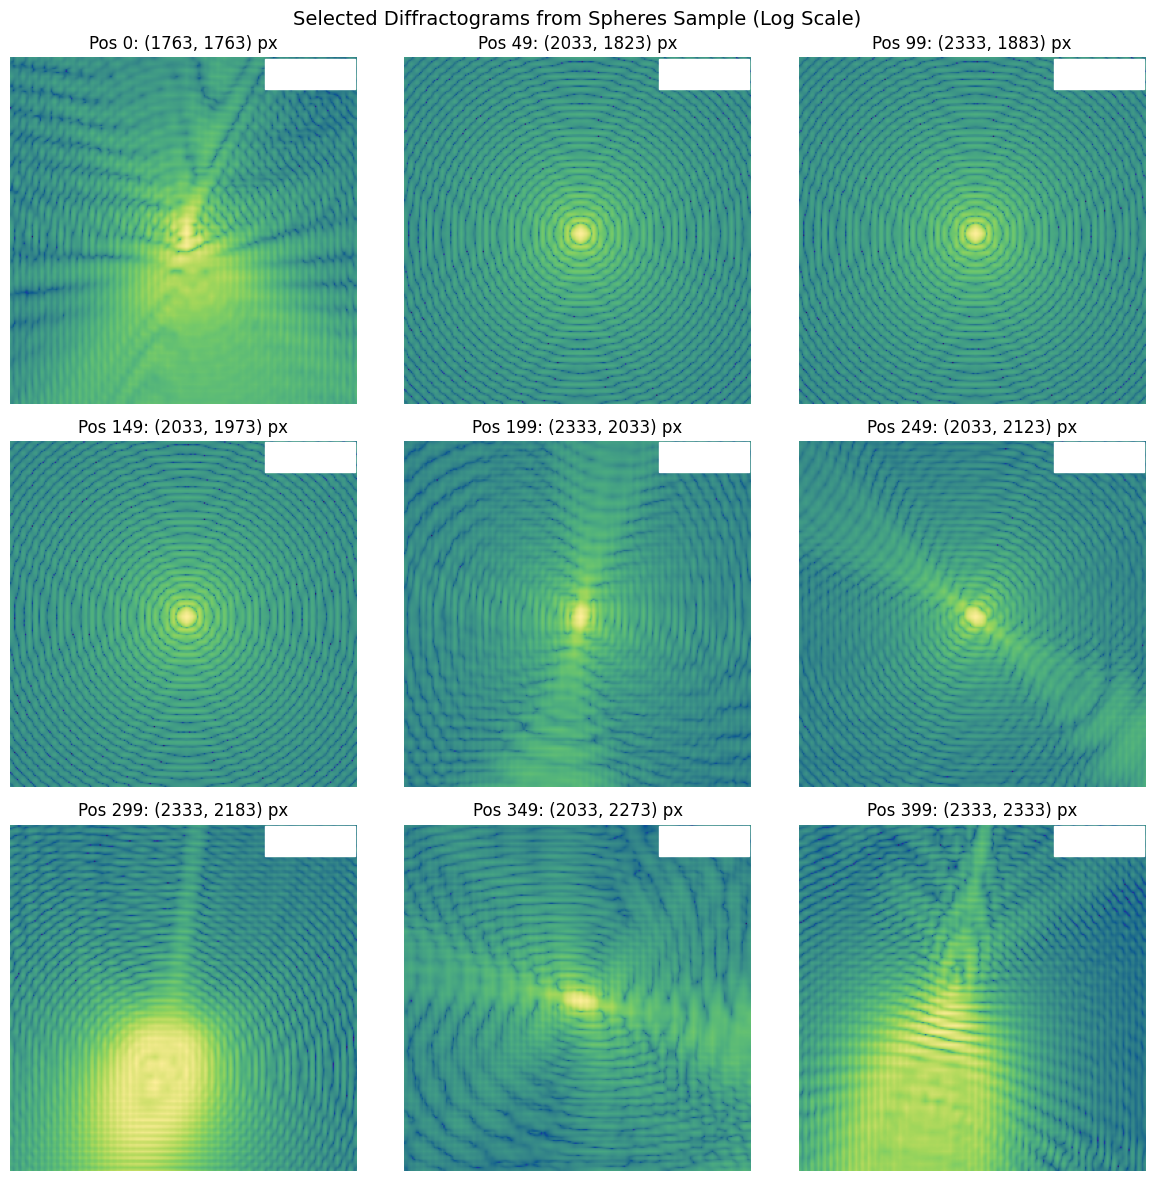

In [16]:
# Visualize a subset of diffractograms (9 evenly spaced)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

indices = jnp.linspace(0, len(positions) - 1, 9).astype(int)

for i, ax in enumerate(axes.flat):
    idx = int(indices[i])
    im = ax.imshow(jnp.log10(microscope_data.image_data[idx] + 1e-10), cmap=cmo.haline)
    pos = positions[idx]
    ax.set_title(f'Pos {idx}: ({pos[0]:.0f}, {pos[1]:.0f}) px')
    scalebar = ScaleBar(microscope_data.dx, 'm', length_fraction=0.25, color='white')
    ax.add_artist(scalebar)
    ax.axis('off')

plt.suptitle('Selected Diffractograms from Spheres Sample (Log Scale)', fontsize=14)
plt.tight_layout()
plt.show()